importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score


mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading and Preprocessing data

unzipping dataset and loading from drive

In [ ]:
# Unzip the dataset (if not already unzipped)
if not os.path.exists("/content/drive/MyDrive/chest_xray_dataset"):
    !unzip /content/drive/MyDrive/Covid19-Pneumonia-Normal.zip -d /content/drive/MyDrive/chest_xray_dataset

# Define the dataset directory after unzipping
dataset_dir = "/content/drive/MyDrive/chest_xray_dataset"

load and preprocess the data

In [ ]:
def load_data(dataset_dir):

    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        labels="inferred",
        label_mode="binary",
        color_mode="grayscale",
        batch_size=32,
        image_size=(128, 128),     # Resize images to 128x128
        shuffle=True,
        seed=123,                   # Seed for reproducibility
        class_names=["PNEUMONIA","NORMAL"]
    )
    # Split the dataset into training and validation sets (80% train, 20% validation)
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

In [ ]:
def preprocess_data(dataset):
  # Normalize the images (rescaling pixel values to [0, 1])
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

    return dataset

# CNN model

In [ ]:
def local_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Client and Server

Client

In [ ]:
# Simulate clients
def simulate_client(client_id, global_weights):
    print(f"Client {client_id+1} starting training...")

    train_data, val_data = load_data(dataset_dir)
    train_data = preprocess_data(train_data)
    val_data = preprocess_data(val_data)
    model = local_cnn_model()

    model.set_weights(global_weights)
    history = model.fit(train_data, epochs=1, verbose=0) # 1 epoch for simplicity


    train_accuracy = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]
    return model.get_weights(), train_loss, train_accuracy

Server

In [ ]:
def fed_server(client_weights):

    new_weights = []

    # Iterate through each layer of the model
    for layer_idx in range(len(client_weights[0])):
        stacked_weights = np.stack([client[layer_idx] for client in client_weights], axis=0)
        averaged_layer = np.mean(stacked_weights, axis=0) # Average of the stacked weights
        new_weights.append(averaged_layer)

    return new_weights

# Evaluation of models

In [ ]:
def evaluate_model(global_model, val_data):
    # validation accuracy and loss
    val_loss, val_accuracy = global_model.evaluate(val_data, verbose=0)  # Use verbose=0 to suppress output

    y_pred = []
    y_true = []
    for images, labels in val_data:
        predictions = global_model.predict(images, verbose=0)
        y_pred.extend(tf.round(predictions).numpy())  # Round predictions to nearest integer (binary classification)
        y_true.extend(labels.numpy())

    # precision, recall, F1 score, and Cohen's Kappa
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    return val_loss, val_accuracy, precision, recall, f1, kappa


# Plot functions

In [ ]:
def plot_train_validate(train_accuracies, val_accuracies, train_losses, val_losses):
    rounds = range(1, len(train_accuracies) + 1)

    # Plot the accuracy trend
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(rounds, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(rounds, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy Trend')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot the loss trend
    plt.subplot(1, 2, 2)
    plt.plot(rounds, train_losses, 'bo-', label='Training Loss')
    plt.plot(rounds, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training vs Validation Loss Trend')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_other_metrics(precisions, recalls, f1_scores, kappa_scores):
    import matplotlib.pyplot as plt

    rounds = range(1, len(precisions) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, precisions, label="Precision")
    plt.plot(rounds, recalls, label="Recall")
    plt.plot(rounds, f1_scores, label="F1 Score")
    plt.plot(rounds, kappa_scores, label="Cohen's Kappa")
    plt.xlabel("Rounds")
    plt.ylabel("Metrics")
    plt.title("Other Metrics Over Federated Rounds")
    plt.legend()
    plt.grid(True)
    plt.show()

# Federated Learning Loop

In [ ]:
# Main federated learning loop
def main_federated_learning(num_clients, num_rounds):
    # Initialize global model
    global_model = local_cnn_model()
    global_weights = global_model.get_weights()

    # To track metrics for plotting
    global_val_accuracies = []
    global_val_losses = []
    avg_train_accuracies = []
    avg_train_losses = []

    # Initialize lists to store metrics across rounds
    precisions = []
    recalls = []
    f1_scores = []
    kappa_scores = []

    for round_num in range(num_rounds):
        print(f"\n--- Round {round_num + 1} ---")

        # Collect weights from all clients and their metrics
        client_weights = []
        round_train_accuracies = []
        round_train_losses = []

        for client_id in range(num_clients):
            # Simulate training on each client and get their weights + validation data
            client_w, train_loss, train_accuracy = simulate_client(client_id, global_weights)
            client_weights.append(client_w)

            # Collect the training accuracy and loss for averaging
            round_train_accuracies.append(train_accuracy)
            round_train_losses.append(train_loss)

        # Calculate average training metrics for this round
        avg_train_accuracy = np.mean(round_train_accuracies)
        avg_train_loss = np.mean(round_train_losses)
        avg_train_accuracies.append(avg_train_accuracy)
        avg_train_losses.append(avg_train_loss)

        print(f"Round {round_num + 1} - Average Client Training Accuracy: {avg_train_accuracy:.4f}, Training Loss: {avg_train_loss:.4f}")

        # Aggregate the weights using FedAvg
        global_weights = fed_server(client_weights)

        # Set the new global weights to the global model
        global_model.set_weights(global_weights)

        # Evaluate the global model on the validation set after each round
        train_data, val_data = load_data("/content/drive/MyDrive/chest_xray_dataset/")
        train_data = preprocess_data(train_data)
        val_data = preprocess_data(val_data)

        # Evaluate the global model
        global_loss, global_accuracy, precision, recall, f1, kappa = evaluate_model(global_model, val_data)

        global_val_accuracies.append(global_accuracy)
        global_val_losses.append(global_loss)

         # Store metrics for plotting later
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        kappa_scores.append(kappa)

        print(f"Round {round_num + 1} - Global Model Validation Accuracy: {global_accuracy:.4f}, Validation Loss: {global_loss:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Cohen's Kappa: {kappa:.4f}")

    # Plot the training and validation trends
    plot_train_validate(avg_train_accuracies, global_val_accuracies, avg_train_losses, global_val_losses)
    plot_other_metrics(precisions, recalls, f1_scores, kappa_scores)


# main function

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Round 1 ---
Client 1 starting training...
Found 3602 files belonging to 2 classes.
Client 2 starting training...
Found 3602 files belonging to 2 classes.
Client 3 starting training...
Found 3602 files belonging to 2 classes.
Client 4 starting training...
Found 3602 files belonging to 2 classes.
Client 5 starting training...
Found 3602 files belonging to 2 classes.
Client 6 starting training...
Found 3602 files belonging to 2 classes.
Client 7 starting training...
Found 3602 files belonging to 2 classes.
Round 1 - Average Client Training Accuracy: 0.8139, Training Loss: 0.3811
Found 3602 files belonging to 2 classes.
Round 1 - Global Model Validation Accuracy: 0.9224, Validation Loss: 0.1861
Precision: 0.8830, Recall: 0.9720, F1 Score: 0.9253, Cohen's Kappa: 0.8450

--- Round 2 ---
Client 1 starting training...
Found 3602 files belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Client 2 starting training...
Found 3602 files belonging to 2 classes.
Client 3 starting training...
Found 3602 files belonging to 2 classes.
Client 4 starting training...
Found 3602 files belonging to 2 classes.
Client 5 starting training...
Found 3602 files belonging to 2 classes.
Client 6 starting training...
Found 3602 files belonging to 2 classes.
Client 7 starting training...
Found 3602 files belonging to 2 classes.
Round 2 - Average Client Training Accuracy: 0.9260, Training Loss: 0.2010
Found 3602 files belonging to 2 classes.
Round 2 - Global Model Validation Accuracy: 0.9460, Validation Loss: 0.1388
Precision: 0.9247, Recall: 0.9636, F1 Score: 0.9438, Cohen's Kappa: 0.8865

--- Round 3 ---
Client 1 starting training...
Found 3602 files belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Client 2 starting training...
Found 3602 files belonging to 2 classes.
Client 3 starting training...
Found 3602 files belonging to 2 classes.
Client 4 starting training...
Found 3602 files belonging to 2 classes.
Client 5 starting training...
Found 3602 files belonging to 2 classes.
Client 6 starting training...
Found 3602 files belonging to 2 classes.
Client 7 starting training...
Found 3602 files belonging to 2 classes.
Round 3 - Average Client Training Accuracy: 0.9556, Training Loss: 0.1377
Found 3602 files belonging to 2 classes.
Round 3 - Global Model Validation Accuracy: 0.9446, Validation Loss: 0.1459
Precision: 0.9117, Recall: 0.9832, F1 Score: 0.9461, Cohen's Kappa: 0.8893

--- Round 4 ---
Client 1 starting training...
Found 3602 files belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Client 2 starting training...
Found 3602 files belonging to 2 classes.
Client 3 starting training...
Found 3602 files belonging to 2 classes.
Client 4 starting training...
Found 3602 files belonging to 2 classes.
Client 5 starting training...
Found 3602 files belonging to 2 classes.
Client 6 starting training...
Found 3602 files belonging to 2 classes.
Client 7 starting training...
Found 3602 files belonging to 2 classes.
Round 4 - Average Client Training Accuracy: 0.9569, Training Loss: 0.1194
Found 3602 files belonging to 2 classes.
Round 4 - Global Model Validation Accuracy: 0.9432, Validation Loss: 0.1356
Precision: 0.9704, Recall: 0.9188, F1 Score: 0.9439, Cohen's Kappa: 0.8919

--- Round 5 ---
Client 1 starting training...
Found 3602 files belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Client 2 starting training...
Found 3602 files belonging to 2 classes.
Client 3 starting training...
Found 3602 files belonging to 2 classes.
Client 4 starting training...
Found 3602 files belonging to 2 classes.
Client 5 starting training...
Found 3602 files belonging to 2 classes.
Client 6 starting training...
Found 3602 files belonging to 2 classes.
Client 7 starting training...
Found 3602 files belonging to 2 classes.
Round 5 - Average Client Training Accuracy: 0.9573, Training Loss: 0.1166
Found 3602 files belonging to 2 classes.
Round 5 - Global Model Validation Accuracy: 0.9529, Validation Loss: 0.1281
Precision: 0.9654, Recall: 0.9384, F1 Score: 0.9517, Cohen's Kappa: 0.9058


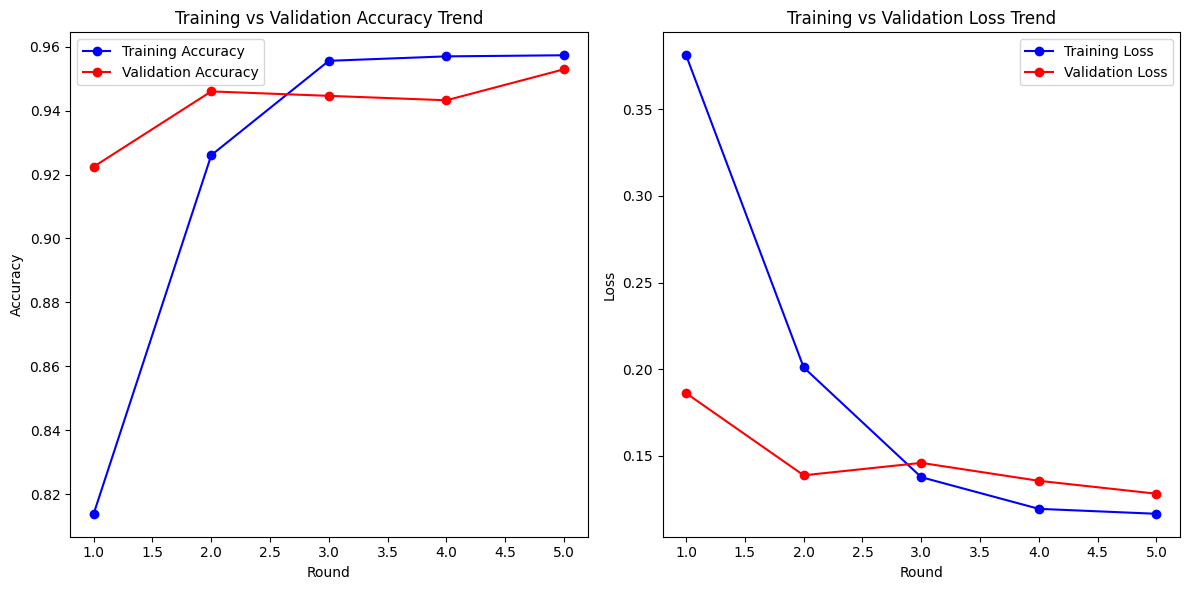

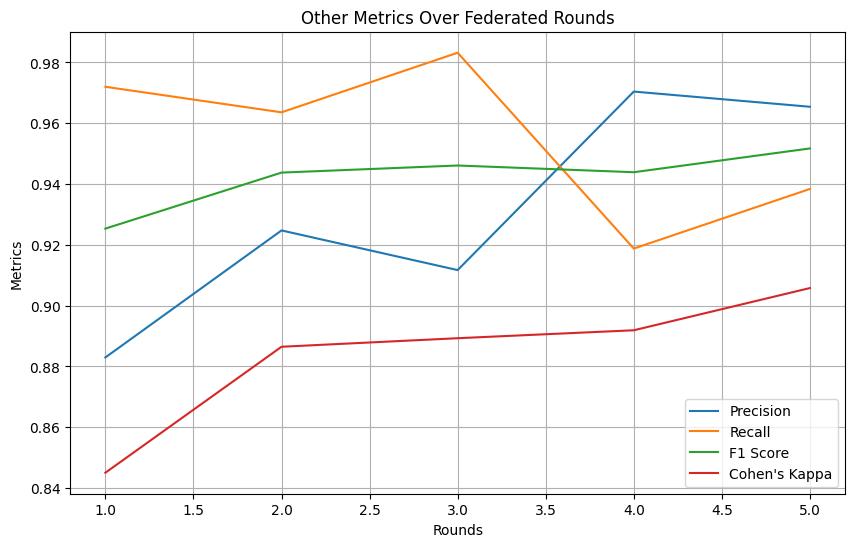

In [ ]:
# Call the main federated learning loop
if __name__ == "__main__":
    main_federated_learning(num_clients=7, num_rounds=5)